In [4]:
import sys
from sklearn.metrics import davies_bouldin_score
import os
import pandas as pd
import polars as pl
import pyarrow as pa
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
import requests
from jinja2 import Template
import json
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import numpy as np

In [2]:
class ClusteringPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, encoder, model, decoder=None):
        self.encoder = encoder
        self.model = model
        self.decoder = decoder
    def fit(self, X, y=None):
        X_encoded = self.encoder.fit_transform(X)
        self.model.fit(X_encoded)
        return self
    def transform(self, X):
        X_encoded = self.encoder.transform(X)
        labels = (self.model.predict(X_encoded)) if hasattr(self.model, 'predict') else self.model.fit_predict(X_encoded)
        return self.decoder(labels) if self.decoder else labels
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

##**Business Understanding**

The goal of using clustering for the Bank Customer Segmentation dataset is to identify customer segments using features about transactions and customers. Using clustering to segment bank customers can help banking clients understand client demographics and create margeting strategies that target certain customer demographics.

##**Data Acquisition**

The dataset, Bank Customer Segmentation, is accessed on Kaggle. The dataset was uploaded to the data hub of Ocular and read by creating a data reader in the visual builder. The reader loaded the dataset from Dremio using Spark and converted it into a Pandas dataframe so it can be easily used for data analysis and model training.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip "/content/drive/MyDrive/archive (1).zip" -d "/content/"

Archive:  /content/drive/MyDrive/archive (1).zip
  inflating: /content/bank_transactions.csv  


In [9]:
!ls -l /content/

total 65992
-rw-r--r-- 1 root root 67564190 Oct 26  2021 bank_transactions.csv
drwx------ 5 root root     4096 Aug  8 16:00 drive
drwxr-xr-x 1 root root     4096 Aug  6 13:39 sample_data


In [10]:
df = pd.read_csv('/content/bank_transactions.csv')

##**Data Cleaning, Preprocessing, and Feature Engineering**

The dataset contains details of transactions made by customers. The each row represents a transaction, but our problem requires us to cluster customers (not transactions). Many transactions map to the same customer id which means that we need to suitably aggregate the transaction records for a single customer, as well as drop irrelevant transaction details.

In [11]:
print(df.head())

  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   
3           866503.21          2/8/16           142714   
4             6714.43          2/8/16           181156   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0  
3                   2060.0  
4                   1762.5  


In [12]:
def data_preprocessing(df):
    # convert customer DOB to datetime and use it to calculate age
    df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce', dayfirst=True)
    df = df[df['CustomerDOB'] <= pd.Timestamp.today()]

    today = pd.Timestamp.today()
    df['CustAge'] = df['CustomerDOB'].apply(lambda dob: (today - dob).days // 365 if pd.notnull(dob) else None)

    # convert strings to numeric values
    df['TransactionAmount (INR)'] = pd.to_numeric(df['TransactionAmount (INR)'], errors='coerce')
    df['CustAccountBalance'] = pd.to_numeric(df['CustAccountBalance'], errors='coerce')

    # one hot encode and reduce location dimensionality
    ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
    # encoding locations
    loc_encoded_sparse = ohe.fit_transform(df[['CustLocation']])
    svd = TruncatedSVD(n_components=10, random_state=42)
    # reducing dimensionality using svd
    loc_svd = svd.fit_transform(loc_encoded_sparse)
    loc_svd_df = pd.DataFrame(loc_svd, columns=[f'LocDim{i+1}' for i in range(loc_svd.shape[1])])
    loc_svd_df['CustomerID'] = df.reset_index(drop=True)['CustomerID']
    # aggregating location details by customer id
    loc_features = loc_svd_df.groupby('CustomerID').mean()

    # aggregate other features
    other_features = df.groupby('CustomerID').agg({
        'TransactionAmount (INR)': ['sum', 'mean'],
        'CustAccountBalance': 'mean',
        'CustGender' :lambda x: x.mode().iloc[0] if not x.mode().empty else None
    }) # aggregating other transaction details by customer id
    other_features.columns = ['_'.join(col) for col in other_features.columns]

    # convert gender to binary
    if 'CustGender_<lambda>' in other_features.columns:
        other_features['CustGender'] = other_features['CustGender_<lambda>'].map({'F': 0, 'M': 1})
        other_features = other_features.drop(columns=['CustGender_<lambda>'], errors='ignore')

    age_df = df[['CustomerID', 'CustAge']].drop_duplicates(subset='CustomerID').set_index('CustomerID')

    # combine all features
    final_df = pd.concat([other_features, loc_features, age_df], axis=1).dropna()

    return final_df

In [13]:
final_df = data_preprocessing(df)
print(final_df.head())

/tmp/ipython-input-3272669570.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce', dayfirst=True)
/tmp/ipython-input-3272669570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustAge'] = df['CustomerDOB'].apply(lambda dob: (today - dob).days // 365 if pd.notnull(dob) else None)
/tmp/ipython-input-3272669570.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

            TransactionAmount (INR)_sum  TransactionAmount (INR)_mean  \
CustomerID                                                              
C1010011                         5106.0                        2553.0   
C1010012                         1499.0                        1499.0   
C1010014                         1455.0                         727.5   
C1010018                           30.0                          30.0   
C1010028                          557.0                         557.0   

            CustAccountBalance_mean  CustGender       LocDim1       LocDim2  \
CustomerID                                                                    
C1010011                  76340.635         0.0  2.203335e-12  1.388509e-10   
C1010012                  24204.490         1.0  1.000000e+00  1.585907e-12   
C1010014                 100112.950         0.0  1.000000e+00  1.585907e-12   
C1010018                    496.180         0.0 -4.821845e-19 -2.456741e-18   
C1010028      

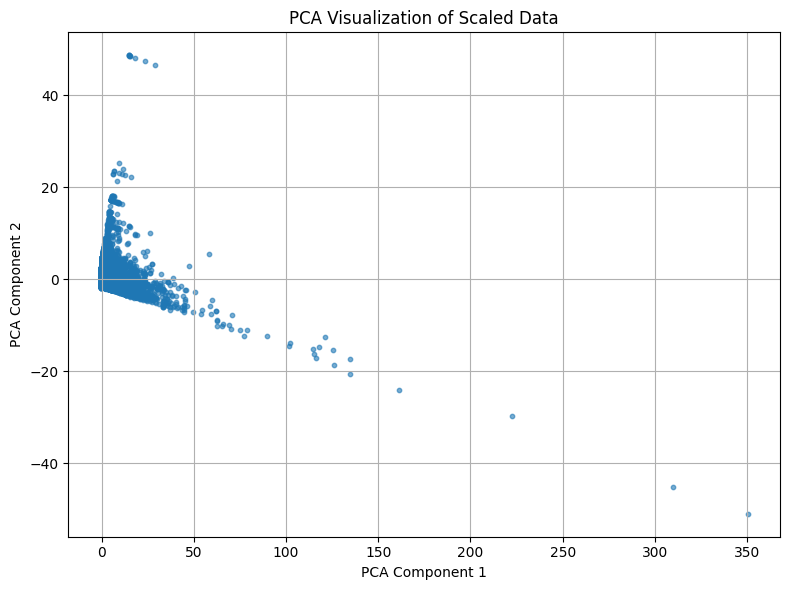

In [14]:
# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_df)

# use PCA to reduce to 2 dimensions
pca_first = PCA(n_components=2)
X_pca = pca_first.fit_transform(X_scaled)

# visualization for PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=10)
plt.title("PCA Visualization of Scaled Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# sample a subset of data
sample_size = 10000
if X_scaled.size > sample_size :
    # if more rows than sample size, take random sample
    idx = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[idx]
else :
    X_sample = X_scaled

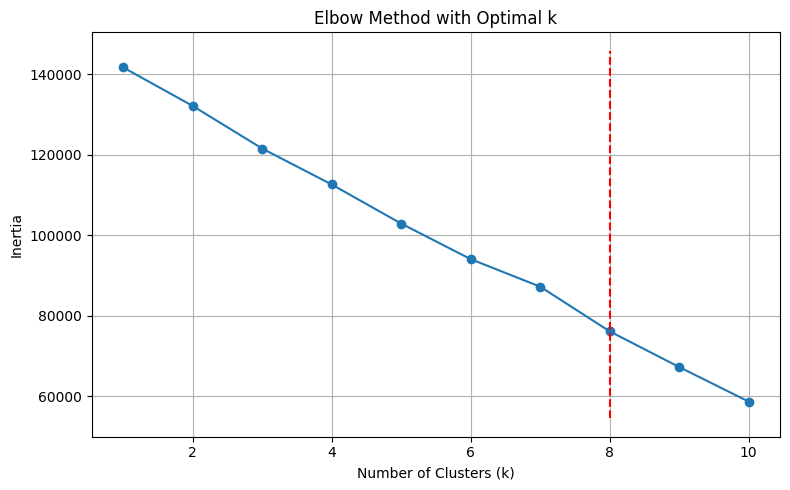

In [15]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)

#Step 3: Find the optimal k using second derivatives
def second_derivative_k(k_vals, inertias):
    first_deriv  = np.diff(inertias)
    second_deriv = np.diff(first_deriv)
    return k_vals[np.argmin(second_deriv) + 2]

optimal_k = second_derivative_k(k_range, inertia)

# Step 4: Plot Elbow Curve with knee point
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.title("Elbow Method with Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.savefig("elbow_plot.png")
plt.show()

# Step 5: Cluster using optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_clusters = kmeans_final.fit_predict(X_sample)
#final_df['Cluster'] = kmeans_clusters

pca = PCA(n_components=2)
X_pca_kmeans = pca.fit_transform(X_sample)

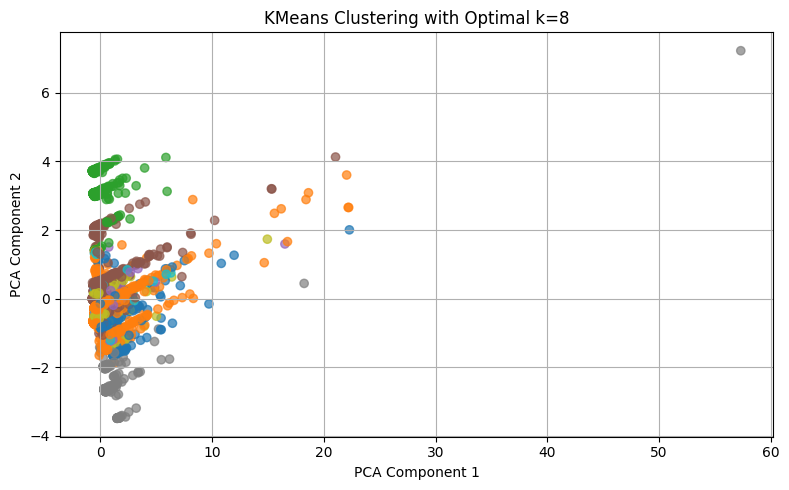

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(X_pca_kmeans[:, 0], X_pca_kmeans[:, 1], c=kmeans_clusters, cmap='tab10', alpha=0.7)
plt.title(f"KMeans Clustering with Optimal k={optimal_k}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("kmeans_clusters.png")
plt.show()

KMeans is used to separate the data into k clusters. The elbow method was used to determine the optimal k value. KMeans is used to minimize the inertia between points and the center of their assigned cluster.

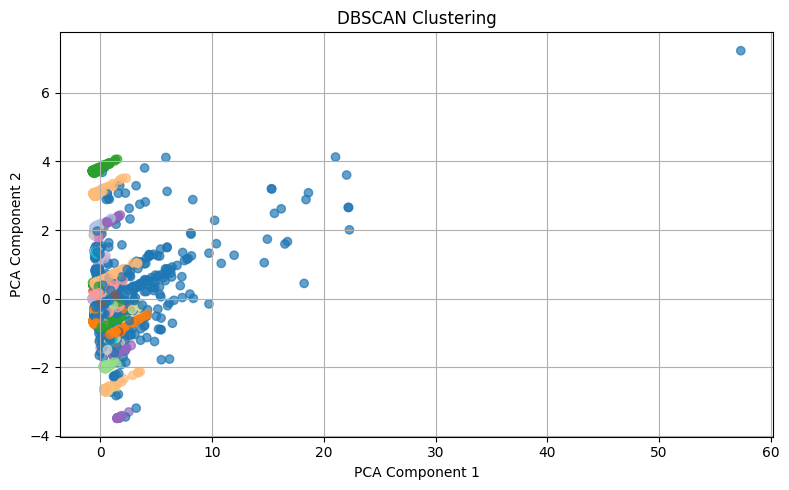

In [17]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_sample)

X_pca_db = PCA(n_components=2).fit_transform(X_sample)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca_db[:, 0], X_pca_db[:, 1], c=dbscan_clusters, cmap='tab20', alpha=0.7)
plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("dbscan_clusters.png")
plt.show()

DBSCAN is used to group points that are near one another and label other points as noise. This method is used to group points into clusters and identify outliers.

In [19]:
kmeans_silhouette = silhouette_score(X_sample, kmeans_clusters)
kmeans_davies_bouldin = davies_bouldin_score(X_sample, kmeans_clusters)
print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")
print(f"KMeans Davies-Bouldin Index: {kmeans_davies_bouldin:.4f}")

dbscan_silhouette = silhouette_score(X_sample, dbscan_clusters)
dbscan_davies_bouldin = davies_bouldin_score(X_sample, dbscan_clusters)
print(f"\nDBScan Silhouette Score: {dbscan_silhouette:.4f}")
print(f"DBScan Davies-Bouldin Index: {dbscan_davies_bouldin:.4f}")

KMeans Silhouette Score: 0.3720
KMeans Davies-Bouldin Index: 1.0982

DBScan Silhouette Score: 0.6853
DBScan Davies-Bouldin Index: 1.3241


In [20]:
#gaussian mixtures model

bic_scores = []
n_components_range = range(1, 11)

for n in n_components_range:
    gmm_temp = GaussianMixture(n_components=n, random_state=42)
    gmm_temp.fit(X_sample)
    bic_scores.append(gmm_temp.bic(X_sample))

optimal_n = n_components_range[np.argmin(bic_scores)]
print("Optimal number of components by BIC:", optimal_n)

Optimal number of components by BIC: 10


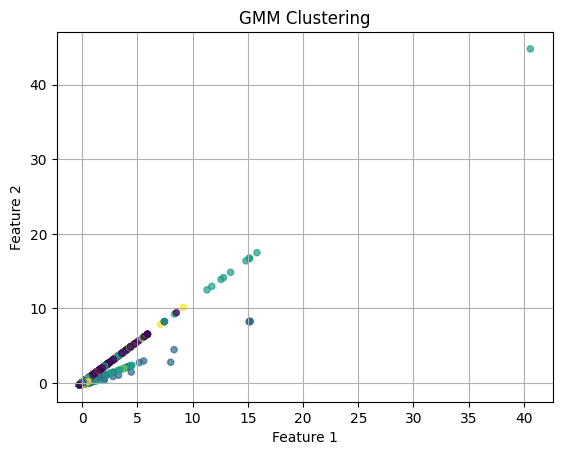

In [21]:
gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
gmm.fit(X_sample)

gmm_clusters = gmm.predict(X_sample)

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=gmm_clusters, cmap='viridis', s=20, alpha=0.7)
plt.title("GMM Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [22]:
gmm_silhouette_score = score = silhouette_score(X_sample, gmm_clusters)

print(f"Gaussian Mixture Model Silhouette Score: {gmm_silhouette_score:.4f}")
print("BIC:", gmm.bic(X_sample))

Gaussian Mixture Model Silhouette Score: 0.3473
BIC: -843578.4945462313


Gaussian Mixture Model (GMM) is used to group points by calculating the probability that a point belongs to a cluster. This method allows points to partially belong to multiple clusters, meaning this method uniquely allows for overlap.

##**Monitoring & Maintenance**

In [23]:
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
# predict clusters on X_sample
kmeans_labels = kmeans_model.fit_predict(X_sample)
sil_score = silhouette_score(X_sample, kmeans_labels)
db_score = davies_bouldin_score(X_sample, kmeans_labels)

Text(0.5, 1.0, 'KMeans Clusters (k=8)')

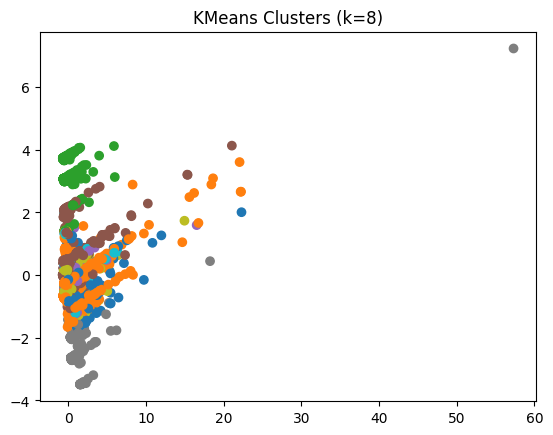

In [26]:
pca_kmeans = PCA(n_components=2).fit_transform(X_sample)
fig = plt.figure()
plt.scatter(pca_kmeans[:, 0], pca_kmeans[:, 1], c=kmeans_labels, cmap='tab10')
plt.title(f"KMeans Clusters (k={optimal_k})")

In [27]:
dbscan_model = DBSCAN(eps=0.8, min_samples=5)
# predict clusters on X_sample
dbscan_labels = dbscan_model.fit_predict(X_sample)

In [28]:
sil_score = silhouette_score(X_sample, dbscan_labels)
db_score = davies_bouldin_score(X_sample, dbscan_labels)

Text(0.5, 1.0, 'DBSCAN Clusters')

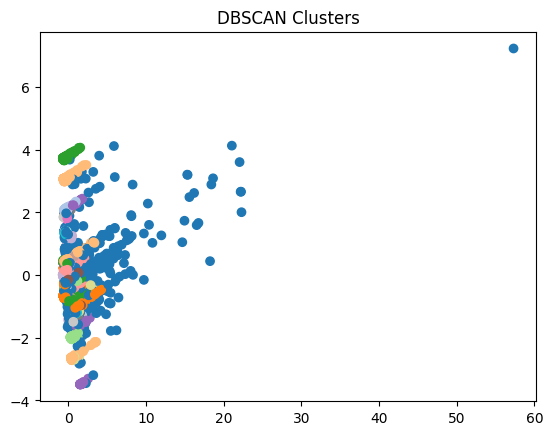

In [29]:
pca_db = PCA(n_components=2).fit_transform(X_sample)
plt.scatter(pca_db[:, 0], pca_db[:, 1], c=dbscan_labels, cmap='tab20')
plt.title("DBSCAN Clusters")

In [30]:
gmm_model = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
# predict clusters on X_sample
gmm_labels = gmm_model.fit_predict(X_sample)

sil_score = silhouette_score(X_sample, gmm_labels)
bic_score = gmm_model.bic(X_sample)

Text(0.5, 1.0, 'GMM Clusters')

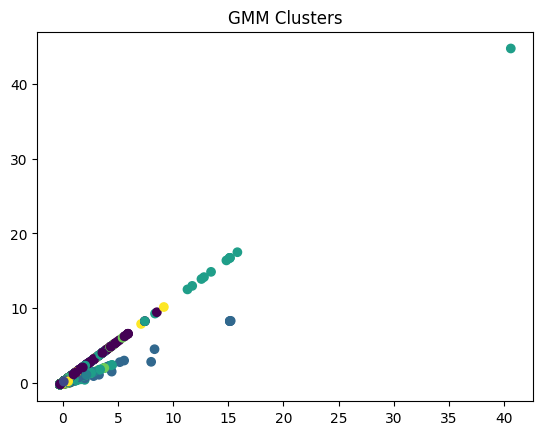

In [31]:
fig = plt.figure()
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=gmm_labels, cmap='viridis')
plt.title("GMM Clusters")

The KMeans, DBSCAN, and GMM models, including key performance metrics and visualizations, were logged using MLflow to track model performance across experiment runs. The end-to-end project was also wrapped in a pipeline structure and saved as a pickle file in MLflow. This part of the project was removed to streamline the workflow and focus on direct model evaluation. Pipeline storage was not essential for the final deployment of the project.